# Use Case: Monitoring the impact of climate change on rain-on-snow events in Svalbard

# User question: Has the frequency of rain-on-snow events changed across Svalbard over the last three decades?  

## Introduction

This Jupyter Notebook assesses the ability of the Copernicus Arctic Regional Reanalysis (CARRA) dataset to study rain-on-snow (ROS) events over Svalbard. The purpose of this introduction is to clarify the reason for selecting CARRA, to explain the significance of ROS events, and to justify the choice of Svalbard as our area of interest.

CARRA is a regional reanalysis dataset that covers the European sector of the Arctic. It is of interest because it can potentially benefit Arctic climate studies by partly overcoming the limitations of the current observing and modelling system. For example, CARRA could supplement in-situ observations in the Arctic by compensating for their temporal gaps and limited spatial coverage. Additionally, thanks to its spatial resolution of 2.5km, CARRA could complement the ERA5 global reanalysis dataset (Hersbach et al., 2020) which might not capture small-spatial scale features due to its spatial resolution of 0.25°x0.25°. Despite its potential, though, the quality of CARRA first needs to be checked. 

This notebook aims to assess the potential of CARRA by analysing a specific problem, namely the change in frequency of ROS events over Svalbard. ROS events occur when rain falls over pre-existing snowpacks and freezes. As it freezes, rain forms a layer of ice that can potentially threaten wildlife, infrastructures, and human communities (e.g., Peeters et al., 2019). This Jupyter Notebook focuses on ROS events because of their relevance to the scientific community, as their frequency of occurrence might be altered by climate change, and a to more general audience, due to their societal impact. 

The relevance of ROS events is particularly pronounced over Svalbard due to the intense warming that has affected the region in the last decades (Hassen-Bauer et al., 2019). To illustrate, the annual-mean temperature averaged over Svalbard increased by 0.87°C/decade between 1971 and 2017, while the global-averaged temperature raised by less than one fourth over the same period (Hanssen-Bauer et al., 2019). This change, which is the local manifestation of a larger-scale phenomenon known as Arctic Amplification (Rantanen et al., 2022), might have modified the frequency of occurrence of ROS events in the region (Hansen et al., 2014) and might continue to do so in the future. Therefore, studying ROS events in Svalbard is important to develop efficient and timely solutions to the challenges that ROS events pose.   

The choice of Svalbard is also motivated by a more technical reason. The CARRA dataset includes two domains that, respectively, cover the western and eastern sectors of the European Arctic. Svalbard lies within both domains. So, the choice of Svalbard helps assess and compare the performance of CARRA's two domains. 

To assess the potential of CARRA, the Jupyter Notebook first compares the 2m temperature and total precipitation from CARRA, ERA5, and five weather stations over Svalbard. Despite the fact that some of these weather stations have being assimilated by the two reanalysis datasets, as indicated by Fig. 2.2.7.1 in the "C3S Arctic regional reanalysis – Full system documentation" (https://datastore.copernicus-climate.eu/documents/reanalysis-carra/CARRAFullSystemDocumentationFinal.pdf; last access on 18/03/2024), this preliminary quality check can return interesting results. Indeed, it can helps assess the overall performance of the datasets. This analysis is then followed by a comparison and a description of the number of ROS events provided by the observations and the reanalysis datasets in the region, and by a brief assessment of whether the number of ROS events has increased in Svalbard since 1990. 


## Take home messages

- Overall, CARRA-East reproduces the number of rain-on-snow (ROS) events over Svalbard during winter more accurately than both CARRA-West and ERA5, as evidenced by observational data. 
    
- Overall, CARRA-East and CARRA-West provide more accurate values of 2m temperature and total precipitation than ERA5 when compared to observations. 

- ERA5 tends to show an overall poorer agreement with observations when compared to CARRA, but it still returns physically significant results. 

- The 2m temperature from ERA5, CARRA-West, and CARRA-East poorly agrees with the observations at the Verlegenhuken weather station in February 1998. Further analysis is needed to determine
  where the problem lies.  

- Both the observational and the reanalysis datasets suggest that timeseries longer than those used in the analysis (December 1990 - February 2022) would help determine whether the rate of change of ROS events over Svalbard has increased. 

## Code

In [1]:
import datetime
import numpy as np
import scipy
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from scipy.stats import t
from matplotlib import colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from c3s_eqc_automatic_quality_control import download, utils, diagnostics, plot


In [2]:
def daily_temperature_reanalysis(da_t2m):
    """
    Given the 2m-temperature from CARRA or ERA5, this function:
        - daily averages the 2m temperature
        - only selects the winter days (December-January-February), with the exception of the 29th of February 
        - converts the temperature from K to °C

    Parameters
    ----------
    da_t2m : xr.DataArray
        DataArray with either ERA5's or CARRA's 2m temperatures over Svalbard. 
        Data have a temporal resolution of 1 hour for ERA5, and of 3 hours for CARRA. 
          
    Results
    -------
    da_daily_djf_t2m : xr.DataArray
        Either ERA5's or CARRA's daily-averaged 2m temperature over Svalbard in winter. 
        See the function description for information on the reprocessing. 
        
    """

    # Compute daily average of temperature 
    da_daily_t2m = da_t2m.resample(forecast_reference_time='1D').mean()
    
    # Only select days in Dec, Jan, and Feb (without the 29th of February)
    dates = pd.date_range(str(year_start)+'-12-01', str(year_stop)+'-02-28', freq='D')
    dates = dates[(dates.month==12) + (dates.month==1) + (dates.month==2)]

    dates_no_2902 = dates[~((dates.month==2) * (dates.day==29))]

    da_daily_djf_t2m = da_daily_t2m.sel(forecast_reference_time=dates_no_2902)
    
    # Conversion from K to °C
    da_daily_djf_t2m = da_daily_djf_t2m - 273.15

    return da_daily_djf_t2m
    

In [3]:
def daily_precipitation_era5(da_tp):
    """
    This function computes the daily accumulated precipitation from ERA5. 
    To compute the daily accumulated precipitation, it follows this procedure:
        1) it removes duplicated dates 
           (I think they might result from the way we download the ERA5 dataset, but the timestamp "31/12 at 18:00" appears 
           twice for each year in the dataset)
        2) it removes the 30th of Nov of each year 
           (this is downloaded even though the download request for ERA5 only includes the days of Dec, Jan, and Feb) 
        3) for each day and at each grid point, it computes the total precipitation that accumulated between the time 06:00 of the 
           day under consideration and the time 06:00 of the following day. This is needed because the weather stations provide
           the precipitation accumulated between at time 06:00 of one day and time 06:00 of the following day. 
           How is the daily accumulated precipitation computed? 
               - we sum over the dimension "leadtime" to obtain, for each day, the total precipitation accumulated between 
                 06:00 and 18:00 and between 18:00 and 06:00 of the following day. 
               - we sum the two value for each day 

    Information on how to compute daily precipitation from ERA5:
    
        - https://confluence.ecmwf.int/display/CKB/ERA5%3A+How+to+calculate+daily+total+precipitation

    Parameters
    ----------
    da_tp : xr.DataArray
        DataArray with accumulated precipitation data over Svalbard as provided by ERA5. 
        Leadtime hours are referenced to time 06:00 and 18:00 of each day. 
        Accumulations are over the hour (the processing period) ending at the forecast step. 
        Units are m. 
        
    Results
    -------
    da_daily_djf_tp : xr.DataArray
        ERA5's daily-accumulated precipitation over Svalbard in winter. 
        See the function description for information on the reprocessing. 
        Units are mm. 
  
    """

    # Remove duplicated dates (needed because the timestamp "31/12 at 18:00" appears twice for each year in the dataset)
    da_tp = da_tp.drop_duplicates(dim='forecast_reference_time')

    # Remove 30th of Nov
    nov30_all_years = [datetime.datetime(year, 11, 30, 18) for year in range(year_start, year_stop)]
    da_tp = da_tp.drop(nov30_all_years, dim='forecast_reference_time')

    # Compute daily aggregated precipitation: 
    #     - for each day 
    #     - at each grid point 
    da_daily_tp = da_tp.sum('leadtime').resample(forecast_reference_time='D').sum()

    # Conversion from m to mm
    da_daily_tp = 1e3 * da_daily_tp 

    # Only select days in Dec, Jan, and Feb (without the 29th of February)
    dates = pd.date_range(str(year_start)+'-12-01', str(year_stop)+'-02-28', freq='D')
    dates = dates[(dates.month==12) + (dates.month==1) + (dates.month==2)]
    
    dates_no_2902 = dates[~((dates.month==2) * (dates.day==29))]    
    
    da_daily_djf_tp = da_daily_tp.sel(forecast_reference_time=dates_no_2902)

    return da_daily_djf_tp


In [4]:
def daily_precipitation_carra(da_tp):
    """
    This function computes the daily precipitation accumulated between 06 UTC and 06 UTC the next day as provided 
    by CARRA-West or CARRA-East.  
    More precisely, this function: 
        - subtracts values when leadtime is 18 and 6
        - separates starting times at midnight and noon 
        - sums the results

    For information on how to compute daily accumulated precipitation, please check the following webpage:  

        - https://confluence.ecmwf.int/pages/viewpage.action?pageId=338485814

    Parameters
    ----------
    da_tp : xr.DataArray
        DataArray with accumulated precipitation data over Svalbard from CARRA. 
        Leadtime hours are referenced to time 00:00 and 12:00 of each day. 
        Accumulations are between the reference time and the ending of each forecast step. 
        Units are mm. 
            
    Results
    -------
    da_daily_djf_tp : xr.DataArray
        Either CARRA-West or CARRA-East's daily-accumulated precipitation over Svalbard in winter. 
        See the function description for information on the reprocessing. 
        Units are mm. 

    """ 

    # Subtract values when leadtime is 18 minus 6    
    da_tp_12h = da_tp.sel(leadtime='18h') - da_tp.sel(leadtime='6h')

    # Separates starting times at midnight and noon 
    da_tp_first_12h = da_tp_12h.where(da_tp_12h['forecast_reference_time'].dt.hour == 0, drop=True)
    da_tp_last_12h = da_tp_12h.where(da_tp_12h['forecast_reference_time'].dt.hour == 12, drop=True)

    da_tp_first_12h['forecast_reference_time'] = pd.to_datetime(da_tp_first_12h['forecast_reference_time'].dt.strftime('%Y-%m-%d'))
    da_tp_last_12h['forecast_reference_time'] = pd.to_datetime(da_tp_last_12h['forecast_reference_time'].dt.strftime('%Y-%m-%d'))
    
    # Sum the results 
    da_daily_tp = da_tp_first_12h + da_tp_last_12h

    # Only select days in Dec, Jan, and Feb (without the 29th of February)
    dates = pd.date_range(str(year_start)+'-12-01', str(year_stop)+'-02-28', freq='D')
    dates = dates[(dates.month==12) + (dates.month==1) + (dates.month==2)]
    
    dates_no_2902 = dates[~((dates.month==2) * (dates.day==29))]    
    
    da_daily_djf_tp = da_daily_tp.sel(forecast_reference_time=dates_no_2902)

    return da_daily_djf_tp
    

In [5]:
def load_weather_stations():
    """
    This function loads and store into a pd.DataFrame the daily-averaged temperature and precipitation 
    provided by the Svalbard's weather stations considered in this study. 

    Results
    -------
    df_sts : pd.DataFrame
        Each row contains the daily-averaged values of temperature and precipitation provided by one
        of the weather stations considered in this study. 
        Each row also provides the name and the ID of each weather station, together with the date when the
        observation was collected. 
        
    names_sts : list
        Name of the Svalbard's weather stations selected in this study. 
    
    """

    # Load weather stations
    # Missing values, indicated with '-', are replaced with NaNs
    df_sts = pd.read_csv('T_Precip_at_5_Svalbard_weather_stations.csv', sep=';', na_values='-') 

    # Rename some columns 
    df_sts = df_sts.rename(columns={'Station':'Station_ID', 'Time(norwegian mean time)':'Time', 'Mean air temperature (24 h)':'Daily_temperature', 'Precipitation (24 h)':'Daily_precipitation'})

    # Name of the weather stations
    # With [:-1], we exclude the following string that is in the data: 
    #    'Data er gyldig per 30.12.2023 (CC BY 4.0), Meteorologisk institutt (MET)'
    names_sts = pd.unique(df_sts['Name'])[:-1]

    return df_sts, names_sts
    

In [6]:
def map_svalbard_weather_stations(lons_sts, lats_sts, names_sts):
    """
    This function creates a map of Svalbard showing the location of the weather stations 
    that have been considered in this study. 

    Parameters
    ----------
    lons_sts, lats_sts : list
        Longitude and latitude of the weather stations used in this study.  

    names_sts : list
        Name of the weather stations used in this study. 

    """

    fig, ax = plt.subplots(1, 1, figsize=(7,7), subplot_kw={'projection':ccrs.Stereographic(central_latitude=78, central_longitude=20)})

    # Draw the coastline of Svalbard and insert the location of the weather stations 
    ax.coastlines('10m')
    ax.set_extent([5,33,75.5,81])
    ax.scatter(lons_sts, lats_sts, c='lime', edgecolor='k', s=50, zorder=2, transform=ccrs.PlateCarree())

    # Write down the name of the weather stations
    d_lon = [0.2, 0.2, 0.2, 0.2, 0.2]
    d_lat = [-0.3, 0.2, 0.2, 0.2, -0.3]
    has = ['left', 'right', 'left', 'right', 'right'] 
    for i_st, name_sts in enumerate(names_sts):
        ax.text(lons_sts[i_st]+d_lon[i_st], lats_sts[i_st]+d_lat[i_st], name_sts, ha=has[i_st],
                fontweight='regular', bbox=dict(facecolor='w', edgecolor='C1', alpha=0.8), transform=ccrs.PlateCarree())

    # Draw coordinates 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') 
    gl.top_labels = True
    gl.left_labels = True 
    gl.xlocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
    gl.ylocator = mticker.FixedLocator([77.5, 80])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    plt.show()
                           

In [7]:
def reformat_weather_station_dataframe(df_sts, name_single_st, year_start, year_stop):
    """
    This function returns the date, and the daily values of temperature and precipitation at one 
    weather station in Svalbard. 
    Use the parameters name_single_st to select the weather station you are interested in.  

    This function further sub-selects the observations for them to cover:
        - the months of December, January, and February. 
        - the period over which we downloaded the ERA5's and CARRA's datasets. 
    
    Parameters
    ----------
    df_sts : pd.DataFrame
        It contains the name, the station ID, the time, the daily values of temperature
        and precipitation for each of the selected weather stations in Svalbard. 
    
    name_single_st : str
        Name of the weather station that you would like to extract.  

    year_start, year_stop : int
        Needed to only select the observations between 'year_start-12-01' and 'year_stop-02-28'
    
    Results
    -------
    sr_single_st_t2m_djf : pd.Series
        It contains the time, and the daily values of temperature provided by the weather station 
        that you selected. Time is the index.   
        NB: Values returned only for the winter period (Dec, Jan, and Feb). 

   sr_single_st_tp_djf : pd.Series
       Same as sr_single_st_t2m_djf, but for the total daily precipitation. 
       
   """

    # Select weather station 
    df_single_st = df_sts[df_sts['Name'] == name_single_st]
    df_single_st = df_single_st.drop(['Name', 'Station_ID'], axis=1)
    df_single_st = df_single_st.set_index('Time')
    df_single_st.index.name = None

    # Conver element of index from str to datetime
    df_single_st.index = pd.to_datetime(df_single_st.index, format="%d.%m.%Y")

    # We sort the dates because their progression must be monotonic for '.loc' to work. 
    # I do not know why, bur the values of temperature and precipitation at Ny-Ålesund are not displaced in              
    # chronological order. 
    # We prefer '.resample('D').asfreq()' over '.sort_index()' because the former fills the missing
    # dates with NaNs. Indeed, the weather stations' datasets do not contain the dates when 
    # neither temperature nor precipitation are recorded. 
    df_single_st = df_single_st.resample('D').asfreq()

    # Extract temperature and precipitation (we will deal with them in different ways)
    sr_single_st_t2m = df_single_st['Daily_temperature']
    sr_single_st_tp = df_single_st['Daily_precipitation']

    # The daily values of precipitation provided by the weather stations are accumulated between 06:00 
    # of given day and 06:00 of the following day. The timestamp associated with the downloaded daily accumulated 
    # precipitation refers to the day when the recording ends.    
    # Here, we modify the timestamps associated to the daily-accumulated precipitation for the to refer to the day 
    # when the recording starts. 
    sr_single_st_tp.index = sr_single_st_tp.index - pd.Timedelta('1D')
    
    # Extend the pd.Series for it to cover all the winter months between 'year_start-12-01' and 'year_stop-02-28'. 
    # The extension is needed because some of the weather stations do not go as back in time as to 'year_start-12-01'. 
    # NaN are placed in location having no values in the previous index.   
    dates = pd.date_range(str(year_start)+'-12-01', str(year_stop)+'-02-28', freq='D')
    dates_djf = dates[(dates.month==12) + (dates.month==1) + (dates.month==2)]
    sr_single_st_t2m_djf = sr_single_st_t2m.reindex(dates_djf)
    sr_single_st_tp_djf = sr_single_st_tp.reindex(dates_djf)
    
    # Remove 29th of Feburay
    dates_djf_no_2902 = dates_djf[~((dates_djf.month==2) * (dates_djf.day==29))]
    sr_single_st_t2m_djf = sr_single_st_t2m_djf.loc[dates_djf_no_2902]
    sr_single_st_tp_djf = sr_single_st_tp_djf.loc[dates_djf_no_2902]
    
    return sr_single_st_t2m_djf, sr_single_st_tp_djf


def group_weather_stations(df_sts, names_sts, year_start, year_stop):
    """
    This function groups into two pd.DataFrames the daily 2m temperature and total precipitation 
    provided by the Svalbard's weather station in winter between 'year_start-12-01' and 'year_stop-02-28'. 
    
    Parameters
    ----------
    df_sts : pd.DataFrame
        It contains the name, the station ID, the time, and the daily values of temperature
        and precipitation for each of the selected weather stations in Svalbard. 
    
    names_sts : str
        Name of the Svalbard's weather stations selected for this study.   

    year_start, year_stop : int
        Needed to only select the observations between 'year_start-12-01' and 'year_stop-02-28'

    Results
    -------
    df_stations_t2m : pd.DataFrame
        Daily-averaged 2m temperature provided by each weather stations between 'year_start-12-01' and 'year_stop-02-28'. 

    df_stations_tp : pd.DataFrame
        Same as df_stations_t2m, but for the total precipitation. 
        
    """

    sr_edgeoya_t2m, sr_edgeoya_tp = reformat_weather_station_dataframe(df_sts, names_sts[0], year_start, year_stop)
    sr_verlegenhuken_t2m, sr_verlegenhuken_tp = reformat_weather_station_dataframe(df_sts, names_sts[1], year_start, year_stop)
    sr_sorkappoya_t2m, sr_sorkappoya_tp = reformat_weather_station_dataframe(df_sts, names_sts[2], year_start, year_stop)
    sr_ny_alesund_t2m, sr_ny_alesund_tp = reformat_weather_station_dataframe(df_sts, names_sts[3], year_start, year_stop)
    sr_svalbard_lufthavn_t2m, sr_svalbard_lufthavn_tp = reformat_weather_station_dataframe(df_sts, names_sts[4], year_start, year_stop)

    # pd.DataFrames where to store the weather stations 
    df_stations_t2m = pd.DataFrame({names_sts[0]: sr_edgeoya_t2m, 
                                    names_sts[1]: sr_verlegenhuken_t2m, 
                                    names_sts[2]: sr_sorkappoya_t2m, 
                                    names_sts[3]: sr_ny_alesund_t2m, 
                                    names_sts[4]: sr_svalbard_lufthavn_t2m})

    df_stations_tp = pd.DataFrame({names_sts[0]: sr_edgeoya_tp, 
                                   names_sts[1]: sr_verlegenhuken_tp, 
                                   names_sts[2]: sr_sorkappoya_tp, 
                                   names_sts[3]: sr_ny_alesund_tp, 
                                   names_sts[4]: sr_svalbard_lufthavn_tp})

    return df_stations_t2m, df_stations_tp


In [8]:
def obs_percentage_per_djf_in_sts(names_sts, year_start, year_stop, df_sts_t2m, df_sts_tp):
    """
    This function creates two subplots (one column, two rows).  
    The upper subplot shows the percentage of temperature observations recorded by each weather station 
    for each winter (December-January-February) between 'year_start-12-01' and 'year_stop-02-28'. 
    The lower subplot shows the same, but for precipitation. 

    Parameters
    ----------
    names_sts : list
        Name of the Svalbard's weather stations selected for this study. 

    year_start, year_stop : int
        First and last year considered. 

    df_sts_t2m, df_sts_tp : pd.DataFrame 
        Daily-averaged 2m temperature and daily-accumulated total precipitation at each of the selected 
        weather stations for each winter day between 'year_start-12-01' and 'year_stop-02-28'. 
        
    """

    n_sts = len(names_sts)
    n_winters = year_stop - year_start

    # Prepare the ticklabels for the x-axis.
    set_xticks_1 = np.array(np.r_[year_start: year_stop], dtype=str)
    set_xticks_2 = np.array(np.r_[year_start+1: year_stop+1], dtype=str)
    set_xticks_1 = [x[2:] for x in set_xticks_1] 
    set_xticks_2 = [x[2:] for x in set_xticks_2] 
    set_xticks = np.char.add(set_xticks_1, '/')
    set_xticks = np.char.add(set_xticks, set_xticks_2)

    # Variable first_decembers useful to exclude the number of observations in 
    # spring (MAM), summer (JJA), and autumn (SON). 
    # This is needed because of the way we count the number of observations within each winter season (see 
    # later in the function). Indeed, this also returns the total number of observations within each other 
    # season (even though this equals to zero in our particular situation). 
    # first_decemebers looks like this: DatetimeIndex(['1990-12-01', '1991-12-01', '1992-12-01', ...]
    first_decembers = pd.date_range(str(year_start)+'-12-01', str(year_stop)+'-02-28', freq='3MS')
    first_decembers = first_decembers[first_decembers.month==12]

    # Plot 
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(16,7.5))

    # colormap temperature
    cmap_t2m = plt.cm.Reds
    norm_t2m = colors.BoundaryNorm(np.r_[0:101:25], 210)

    # colormap precipitation 
    cmap_tp = plt.cm.Blues
    norm_tp = colors.BoundaryNorm(np.r_[0:101:25], 210)

    # Run through all the stations 
    for i_st in range(n_sts):

        name_st = names_sts[i_st]
        
        # Temperature subplot
        sr_t2m = df_sts_t2m[name_st]

        # Count the number of observations within each 3-month period (starting from Dec of year_start)
        # Pick only the counts for DJFs 
        n_t2m = sr_t2m.resample('3MS').count()[first_decembers]    
        pct_t2m = 100 * n_t2m / 90    # Percentage of observations over each winter
        # DJF when there are some gaps, but there are not only gaps 
        p_t2m = axs[0].scatter(np.r_[0:n_winters][(pct_t2m!=0) * (pct_t2m!=100)], 
                               -i_st*np.ones(n_winters)[(pct_t2m!=0) * (pct_t2m!=100)], c=pct_t2m[(pct_t2m!=0) * (pct_t2m!=100)], 
                               cmap=cmap_t2m, norm=norm_t2m, edgecolor='k', linewidth=0.5,)
        # DJF with not gaps are shown in black
        axs[0].scatter(np.r_[0:n_winters][pct_t2m==100], -i_st*np.ones(n_winters)[pct_t2m==100], c='k', edgecolor='k', linewidth=0.5)    
        # DJF with only gaps are shown in white
        axs[0].scatter(np.r_[0:n_winters][pct_t2m==0], -i_st*np.ones(n_winters)[pct_t2m==0], c='w', edgecolor='k', linewidth=0.5)    

        # Precipitation subplot (same structure as for temperature)
        sr_tp = df_sts_tp[name_st]
        n_tp = sr_tp.resample('3MS').count()[first_decembers]
        pct_tp = 100 * n_tp / 90
        p_tp = axs[1].scatter(np.r_[0:n_winters][(pct_tp!=0) * (pct_tp!=100)], 
                              -i_st*np.ones(n_winters)[(pct_tp!=0) * (pct_tp!=100)], c=pct_tp[(pct_tp!=0) * (pct_tp!=100)], 
                              cmap=cmap_tp, norm=norm_tp, edgecolor='k', linewidth=0.5,)
        p_100 = axs[1].scatter(np.r_[0:n_winters][pct_tp==100], -i_st*np.ones(n_winters)[pct_tp==100], c='k', edgecolor='k', linewidth=0.5)
        p_0 = axs[1].scatter(np.r_[0:n_winters][pct_tp==0], -i_st*np.ones(n_winters)[pct_tp==0], c='w', edgecolor='k', linewidth=0.5)
        
    # Set up x- and y-axes 
    ps = [p_t2m, p_tp]
    for i, iax in enumerate(axs):
        iax.set_xticks(np.r_[0:n_winters])
        iax.set_xticklabels(set_xticks, rotation=60)
        iax.set_yticks(np.r_[0:-n_sts:-1])
        iax.set_yticklabels(names_sts)
        cbar = fig.colorbar(ps[i], ax=iax, drawedges=True)
        cbar.set_label('Percentage of observations [%]') 
        cbar.ax.hlines([0, 100], [0, 0], [1, 1], colors=['w', 'k'], linewidth=[8,8])
    
    plt.show() 


In [9]:
def dist_from_weather_station(da_reanalysis, lon_st, lat_st):
    """
    This function computes the distance (in km) between one of the weather stations and 
    each grid point of the reanalysis dataset.  

    This operation is not done with for loop, but in parallel. 
    This requires that:
        - the lon and the lat of ERA5, which are 1D arrays, are turned into two 2D np.arrays with 
          the same shape as the ERA5's grid
    Instead:
        - the lon and the lat of CARRA-West and CARRA-East are not modified because they are 
          already 2-dimensional 
        - the lon and the lat of the weather station (two floats) are left unchanged   
          
    Parameters
    ----------
    da_reanalysis : xr.DataArray
        reanalysis dataset that has been selected (ERA5, CARRA-West, or CARRA-East) 
  
    lon_st, lat_st : float, float
        longitude and latitude of the weather station considered 
        
    Result
    ------
    d : np.array 
        distance (in km) between each grid point of the reanalysis dataset and the
        weather station under consideration.
        It is a 2D array with the same shape of the spatial grid of da_reanalysis. 
    
    """

    r = 6378.137    # Radius of the Earth (in km) 

    # np.arrays with the longitude and latitude of the reanalysis data
    # These are 1D for ERA5, and 2D for CARRA-West and CARRA-East 
    lons_reanalysis = da_reanalysis.longitude.values
    lats_reanalysis = da_reanalysis.latitude.values

    # The 'if' statement checks whether the reanalyis considered is ERA5
    # If so, lons_reanalysis and lats_reanalysis are turned into 2D array
    # for them to have the shape of the ERA5's grid 
    if len(lons_reanalysis.shape) == 1:
        lons_reanalysis = np.tile(da_reanalysis.longitude.values, (len(da_reanalysis.latitude), 1))
        lats_reanalysis = np.tile(da_reanalysis.latitude.values, (len(da_reanalysis.longitude), 1)).T

    # Conversion: degrees to radians 
    lons_reanalysis_r = 2*np.pi*lons_reanalysis/360
    lats_reanalysis_r = 2*np.pi*lats_reanalysis/360
    lon_st_r = 2*np.pi*lon_st/360
    lat_st_r = 2*np.pi*lat_st/360

    d = r * np.arccos(np.sin(lats_reanalysis_r)*np.sin(lat_st_r) + np.cos(lats_reanalysis_r)*np.cos(lat_st_r)*np.cos(lons_reanalysis_r-lon_st_r))
    
    return d
    

def reanalysis_data_at_weather_stations(da_reanalysis, lons_sts, lats_sts, names_sts, dates):
    """
    This function considers the daily-averaged 2m-temperature or the daily-accumulated total precipitation from 
    one these reanalysis datasets: ERA5, CARRA-West, or CARRA-East.  
    It selects the value of temperature or precipitation at the grid points closest to each weather station. 

    Parameters
    ----------
    da_reanalysis : xr.DataArray
        3D array 
        Daily-averaged 2m-temperature or daily-accumulated total precipitation from ERA5, CARRA-West, or CARRA-East.  
        
    lons_sts, lats_sts : list, list
        Longitude and latitude of the weather stations.  

    names_sts : np.array
        Names of the selected weather stations. 

    dates : pandas.core.indexes.datetimes.DatetimeIndex
        Dates considered -> Dec, Jan, Feb months between year_start+'-12-01' and year_stop+'-02-28'

    Results
    -------
    df_reanalysis_at_sts : xr.DataFrame
        Values of da_reanalysis at the grid points closest to the weather stations.  
        
    """

    n_sts = len(lons_sts)

    # Arrays where to store the indices of the grid points closest to the weather stations. 
    ind_row_sts = np.NaN * np.ones(n_sts)
    ind_col_sts = np.NaN * np.ones(n_sts)

    # Run through each weather station 
    for i_st in range(n_sts):

        # Distance (in km) between the selected weather station and each grid point of the reanalysis dataset. 
        d_from_st = dist_from_weather_station(da_reanalysis, lons_sts[i_st], lats_sts[i_st])

        # Row and colunm indices of the grid point closest to the weather station. 
        ind_row_sts[i_st] = np.argmin(d_from_st)//d_from_st.shape[1]
        ind_col_sts[i_st] = np.argmin(d_from_st)%d_from_st.shape[1]

    # Select the values of da_reanalysis at each specific par (ind_row_sts[i_st], ind_col_sts[i_st]) location 
    # with i_st ranging from 0 to n_sts (excluded) 
    da_ind_row_sts = xr.DataArray(ind_row_sts, dims=['weather_stations']).astype(dtype=int)
    da_ind_col_sts = xr.DataArray(ind_col_sts, dims=['weather_stations']).astype(dtype=int)
    da_reanalysis_at_sts = da_reanalysis[:, da_ind_row_sts, da_ind_col_sts]

    df_reanalysis_at_sts = pd.DataFrame(da_reanalysis_at_sts.values, index=dates, columns=names_sts)
    
    return df_reanalysis_at_sts 


def values_at_single_station(df_stations, df_era5_at_sts, df_carra_west_at_sts, df_carra_east_at_sts, name_st):
    """
    We select either the 2m temperature or the total precipitation of a weather station. 
    We then create two pd.DataFrames. 
    One pd.DataFrame stores the values provided by the weather station, ERA5, CARRA-West, and CARRA-East.  
    The other stores the difference between the values provided by the weather station and those
    provided by ERA5, CARRA-West, and CARRA-East. 

    Parameters
    ----------
    df_stations : pd.DataFrame
        Timeseries of either the 2m temperature or the total precipitation provided by one weather station. 

    df_era5_at_sts : pd.DataFrame
        Timeseries of either the 2m temperature or the total precipitation provided by ERA5 at the grid point closest to each weather station. 

    df_carra_west_at_sts : pd.DataFrame
        Same as df_era5_at_sts, but for CARRA-West. 
        
    df_carra_east_at_sts : pd.DataFrame
        Same as df_era5_at_sts, but for CARRA-East. 

    name_st : str
        Name of the selected weather station.  

    Results
    -------
    df_st : pd.DataFrame 
        At the selected weather station, timeseries of either the 2m temperature or the total precipitation provided by 
        the weather station and by the three reanalysis datasets at the grid point closest to the station. 

    df_diff_st : pd.DataFrame
        At the selected weather station, difference between the observations provided by the weather station and the 
        values provided by ERA5, CARRA-West, and CARRA-East. 
    
    """

    # We select one weather station. We store into an individual pd.DataFrame either the 2m temperature or the 
    # total precipitation provided by the weather station and by the three reanalysis datasets at the grid point 
    # closest to the station. 
    df_st = pd.DataFrame({'weather_station': df_stations[name_st], 
                          'ERA5': df_era5_at_sts[name_st], 
                          'CARRA-WEST': df_carra_west_at_sts[name_st], 
                          'CARRA-EAST': df_carra_east_at_sts[name_st]})

    # Difference between the observations provided by the weather station and the values by ERA5, CARRA-West, 
    # and CARRA-East. 
    df_diff_st = df_st.assign(**df_st[['ERA5','CARRA-WEST', 'CARRA-EAST']].sub(df_st['weather_station'], axis=0).add_prefix(''))
    
    return df_st, df_diff_st


def values_at_all_stations(df_stations_t2m, df_stations_tp, da_era5_t2m, da_era5_tp, da_carra_west_t2m, da_carra_west_tp, da_carra_east_t2m, da_carra_east_tp, lons_sts, lats_sts, year_start, year_stop):
    """
    This function extends the function "values_at_single_station" to all the weather stations. 
    Furthermore, this function considers both the 2m tempetature and the total precipitation. 
    It stores the pd.DataFrames for 2m temperature and total precipitation into individual python dictionaries. 

    Parameters
    ----------
    df_stations_t2m : pd.DataFrame
        Daily-averaged 2m temperature provided by the weather stations. 
    
    df_stations_t2p : pd.DataFrame
        Daily-accumulated total precipitation provided by the weather stations. 

    da_era5_t2m, da_era5_tp : xr.DataArray
        3D array 
        2m-temperature and daily precipitation from ERA5. 

    da_carra_west_t2m, da_carra_west_tp : xr.DataArray
        Same as da_era5_t2m, da_era5_tp, but for CARRA-West. 

    da_carra_east_t2m, da_carra_east_tp : xr.DataArray
        Same as da_era5_t2m, da_era5_tp, but for CARRA-East. 

    lons_sts, lats_sts : np.array, np.array 
        lon and lat of the weather stations. 

    year_start, year_stop : int
        First and last year considered. 
        
    Results
    -------
    dc_t2m_at_sts : dict
        For each weather station, we store into a pd.DataFrame the timeseries of 2m temperature provided by the weather station and 
        by the three reanalysis datasets at the grid point closest to the station. Then, we store the pd.DataFrame for each weather
        station into a python dictonary. 
    
    dc_tp_at_sts : dict
        Same as dc_t2m_at_sts, but for the total precipitation. 

    dc_diff_t2m_at_sts : dict
        For each weather station, we also store into a pd.DataFrame the difference between the 2m temperature provided by the weather 
        station and that provided by ERA5, CARRA-West, and CARRA-East. 
    
    dc_diff_tp_at_sts : dict
        Same as dc_diff_tp_at_sts, but for the total precipitation. 

    """

    # Only select winter days (December-January-February) between 'year_start-12-01' and 'year_stop-02-28' (without the 29th of February)
    dates = pd.date_range(str(year_start)+'-12-01', str(year_stop)+'-02-28', freq='D')
    dates = dates[(dates.month==12) + (dates.month==1) + (dates.month==2)]
    dates_no_2902 = dates[~((dates.month==2) * (dates.day==29))] 
    
    # For each reanalysis dataset, extract the 2m temperature and total precipitation at the grid points closest to each weather station 
    # ERA5
    df_era5_t2m_at_sts = reanalysis_data_at_weather_stations(da_era5_t2m, lons_sts, lats_sts, names_sts, dates_no_2902)
    df_era5_tp_at_sts = reanalysis_data_at_weather_stations(da_era5_tp, lons_sts, lats_sts, names_sts, dates_no_2902)

    # CARRA-West
    df_carra_west_t2m_at_sts = reanalysis_data_at_weather_stations(da_carra_west_t2m, lons_sts, lats_sts, names_sts, dates_no_2902)
    df_carra_west_tp_at_sts = reanalysis_data_at_weather_stations(da_carra_west_tp, lons_sts, lats_sts, names_sts, dates_no_2902)

    # CARRA-East 
    df_carra_east_t2m_at_sts = reanalysis_data_at_weather_stations(da_carra_east_t2m, lons_sts, lats_sts, names_sts, dates_no_2902)
    df_carra_east_tp_at_sts = reanalysis_data_at_weather_stations(da_carra_east_tp, lons_sts, lats_sts, names_sts, dates_no_2902)

    # For each weather station, we store into a pd.DataFrame the timeseries of 2m temperature provided by the weather station and 
    # by the three reanalysis datasets at the grid point closest to the station. Then, we store the pd.DataFrame for each weather
    # station into a python dictonary. 
    # For each weather station, we also store into a pd.DataFrame the difference between the 2m temperature provided by the weather 
    # station and that provided by ERA5, CARRA-West, and CARRA-East. Then, we store the pd.DataFrame for each weather station into 
    # a python dictonary. 
    # We repeat the same procedure for the total precipitation. 
    dc_t2m_at_sts = dict()
    dc_tp_at_sts = dict()
    dc_diff_t2m_at_sts = dict()
    dc_diff_tp_at_sts = dict()

    for name_st in names_sts:
        dc_t2m_at_sts[name_st], dc_diff_t2m_at_sts[name_st] = values_at_single_station(df_stations_t2m, df_era5_t2m_at_sts, df_carra_west_t2m_at_sts, df_carra_east_t2m_at_sts, name_st)
        dc_tp_at_sts[name_st], dc_diff_tp_at_sts[name_st] = values_at_single_station(df_stations_tp, df_era5_tp_at_sts, df_carra_west_tp_at_sts, df_carra_east_tp_at_sts, name_st)

    return dc_t2m_at_sts, dc_diff_t2m_at_sts, dc_tp_at_sts, dc_diff_tp_at_sts


In [10]:
def plots_t2m(dc_t2m_at_sts, dc_diff_t2m_at_sts, names_sts):
    """
    This function has as many rows as the weather stations (five) and as many columns as
    the reanalysis datasets (three). 
    Each row is made of three scatter plots. The scatter plot on the left is used to compare 
    the daily-averaged 2m temperature provided by the weather station (x-axis) and ERA5 (y-axis). 
    The plots in the middle and on the right follow the structure, but shows the comparison with 
    CARRA-West and CARRA-East, respectively. 

    Parameters
    ----------
    dc_t2m_at_sts : dict
        Each element of the dict consist of a pd.DataFrame and refers to one of the weather stations.  
        The pd.DataFrame contains the 2m temperature provided by the weather station, and by ERA5, CARRA-West, 
        and CARRA-East at the grid point closest to each weather station.   
    
    dc_diff_t2m_at_sts : dict
        Each element of the dict consist of pd.DataFrame and refers to one of the weather stations. 
        The pd.DataFrame contains the difference between the 2m temperature provided by the weather station and ERA5, 
        CARRA-West, and CARRA-East, respectively.  
        
    names_sts : list
        Name of the Svalbard's weather stations selected for this study.  
    
    """

    fig, axs = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(25,30)) 

    # Run through all the weather stations
    for i_st, name_st in enumerate(names_sts):
    
        names_reanalysis = ['ERA5', 'CARRA-WEST', 'CARRA-EAST']
        color_col = ['C0', 'C1', 'C2']
        for i_col in range(3):
            axs[i_st,i_col].scatter(dc_t2m_at_sts[name_st]['weather_station'], dc_t2m_at_sts[name_st][names_reanalysis[i_col]], alpha=0.6, c=color_col[i_col])
            axs[i_st,i_col].plot([-40,10], [-40,10], c='gray', lw=0.5, ls='--')

            # Compute the bias and the RMSE. Show them in a box at the bottom right of each subplot. 
            bias =  dc_diff_t2m_at_sts[name_st][names_reanalysis[i_col]].mean()
            rmse = dc_diff_t2m_at_sts[name_st][names_reanalysis[i_col]].std()
            axs[i_st,i_col].text(0.55, 0.05, 'bias=' + str(round(bias, 2)) + ',   ' + 'RMSE=' + str(round(rmse, 2)), transform=axs[i_st,i_col].transAxes, fontsize=14, 
                                 bbox=dict(facecolor='w', edgecolor=color_col[i_col], alpha=0.8))
        
        axs[i_st,1].set_title(name_st, fontsize=16)

    # Set x- and y-labels. 
    for i, iax in enumerate(axs.flatten()):
        iax.grid()
        if i%3==0:
            iax.set_ylabel('reanalysis [°C]')
        if i>=12:
            iax.set_xlabel('weather station [°C]')
        
    plt.show() 


def plots_tp(dc_tp_at_sts, dc_diff_tp_at_sts, names_sts):
    """
    This function has two rows and three columns. It only has two rows because the total precipitation 
    is only provided by two of the selected weather stations over Svalbard (Ny-Ålesund and Svalbard 
    Lufthavn).  
    Each row is made of three scatter plots. The scatter plot on the left is used to 
    compare the total precipitation from the weather station (x-axis) and from ERA5 (y-axis). 
    The plots in the middle and on the right follow the same structure, but show the 
    comparison with CARRA-West and CARRA-East respectively. 

    Parameters
    ----------
    dc_tp_at_sts : dict
        Each element of the dict consist in pd.DataFrame and refers to a weather station location.  
        This contains the total precipitation from the weather station, ERA5, CARRA-West, and CARRA-East.  
    
    dc_diff_tp_at_sts : dict
        Each element of the dict consist in pd.DataFrame and refers to a weather station location.  
        The pd.DataFrame contains the difference between the total precipitation provided by the weather station and ERA5, 
        CARRA-West, and CARRA-East, respectively.  
        
    names_sts : list
        Name of the five weather stations selected. 
        
    """

    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(25,10)) 
    
    # Run through all the weather stations
    for i_st, name_st in enumerate(names_sts[-2:]):
    
        names_reanalysis = ['ERA5', 'CARRA-WEST', 'CARRA-EAST']
        color_col = ['C0', 'C1', 'C2']
        for i_col in range(3):
            axs[i_st,i_col].scatter(dc_tp_at_sts[name_st]['weather_station'], dc_tp_at_sts[name_st][names_reanalysis[i_col]], alpha=0.2, s=5, c=color_col[i_col])
            axs[i_st,i_col].plot([0,100], [0,100], c='gray', lw=0.5, ls='--')
            
            # Compute the bias and the RMSE. Show them in a box at the bottom right of each subplot. 
            bias =  dc_diff_tp_at_sts[name_st][names_reanalysis[i_col]].mean()
            rmse = dc_diff_tp_at_sts[name_st][names_reanalysis[i_col]].std()
            axs[i_st,i_col].text(0.55, 0.05, 'bias=' + str(round(bias, 2)) + ',   ' + 'RMSE=' + str(round(rmse, 2)), transform=axs[i_st,i_col].transAxes, fontsize=14, 
                                 bbox=dict(facecolor='w', edgecolor=color_col[i_col], alpha=0.8))
         
        axs[i_st,1].set_title(name_st, fontsize=16)
        
    # Set x- and y-labels. 
    for i, iax in enumerate(axs.flatten()):
        iax.grid()
        if i%3==0:
            iax.set_ylabel('reanalysis [mm]')
        if i>=3:
            iax.set_xlabel('weather station [mm]')
    
    plt.show() 


def show_t2m_difference_at_verlegenhuken(dc_t2m_at_sts, dc_diff_t2m_at_sts):
    """
    This function is specifically designed to show the surprisingly large temperature difference between the 
    Verlegenhuken weather station and the three reanalysis datasets in February 1998. 
    This function creates 4 subplots: one subplot fills the entire upper row, whereas the lower row is equally 
    split among the remaining three subplots. 
    The upper subplot shows the difference between the 2m temperature from CARRA-East and the weather
    station at Verlegenhuken over the entire period considered. CARRA-East is shown as an example. It 
    could have very well been ERA5 or CARRA-West. 
    The lower subplots show the 2m temperature as Verlegenhuken as provided by the weather station and by
    each reanalysis dataset (a subplot per reanalysis) between December 1997 and February 1998. 

    Parameters
    ----------
    dc_t2m_at_sts : dict
        Each element of the dict consist of a pd.DataFrame and refers to one of the weather stations.  
        The pd.DataFrame contains the 2m temperature provided by the weather station, and by ERA5, CARRA-West, 
        and CARRA-East at the grid point closest to each weather station.   
    
    dc_diff_t2m_at_sts : dict
        Each element of the dict consist of pd.DataFrame and refers to one of the weather stations. 
        The pd.DataFrame contains the difference between the 2m temperature provided by the weather station and ERA5, 
        CARRA-West, and CARRA-East, respectively.  
        
    """

    fig = plt.figure(figsize=(25,10)) 

    # Create 4 subplots over two rows.
    gs = fig.add_gridspec(2, 3)
    ax0 = fig.add_subplot(gs[0,:])    # create upper subplot (it occupies the entire row)
    ax10 = fig.add_subplot(gs[1,0])   # create the lower subplots
    ax11 = fig.add_subplot(gs[1,1])
    ax12 = fig.add_subplot(gs[1,2])
    axs = [ax0, ax10, ax11, ax12]

    # Upper subplot
    dc_diff_t2m_at_sts['Verlegenhuken']['CARRA-EAST'].plot(ax=ax0, label='2m temperature difference between CARRA-East and the weather station')

    # Lower subplots 
    dc_t2m_at_sts['Verlegenhuken'][['weather_station', 'ERA5']].loc['1997-12-01':'1998-02-28'].plot(ax=ax10)
    dc_t2m_at_sts['Verlegenhuken'][['weather_station', 'CARRA-WEST']].loc['1997-12-01':'1998-02-28'].plot(ax=ax11)
    dc_t2m_at_sts['Verlegenhuken'][['weather_station', 'CARRA-EAST']].loc['1997-12-01':'1998-02-28'].plot(ax=ax12)

    for iax in axs:
        iax.grid() 
        iax.legend() 
        iax.set_ylabel('[°C]')
    
    plt.show()    


In [11]:
def monthly_ros_events_at_single_station(df_t2m, df_tp, year_start, year_stop, obs_gaps):
    """
    This function counts the number of rain-on-snow (ROS) events per winter at one weather station using the 
    2m temperature and total precipitation provided by:
        - the weather station 
        - ERA5
        - CARRA-West
        - CARRA-East

    Rain-on-snow events defined as: 
        - daily-averaged temperature > 0 °C
        - daily-accumulated total precipitation > 1 mm
        
    Parameters
    ----------
    df_t2m : pd.DataFrame
        Daily-averaged 2m-temperature provided by the selected weather station in winter.  

    df_tp : pd.DataFrame
        Daily-accumulated total precipitation provided by the selected weather station in winter.   
 
    year_start, year_stop : int
        First and last year considered. 

    obs_gaps : bool
        If True, we artificially fill the reanalysis data with the same gaps as in the observations
        before computing the number of ROS events for each winter. 
        If False, the reanalysis data are left unaltered. 
    
    Results
    -------
    df_n_ros : pd.DataFrame
        Total number of ROS events for each winter season.  
    
    """

    df_t2m = df_t2m[['weather_station', 'ERA5', 'CARRA-WEST', 'CARRA-EAST']]
    df_tp = df_tp[['weather_station', 'ERA5', 'CARRA-WEST', 'CARRA-EAST']]

    # If obs_gaps==True, artificially fill the reanalysis data with the same gaps as in the observations
    if obs_gaps==True:
        df_t2m.loc[df_t2m.isnull().any(axis=1), :] = np.nan
        df_tp.loc[df_tp.isnull().any(axis=1), :] = np.nan
    
    # Rain-on-snow events
    df_ros = (df_t2m>0) * (df_tp>1)

    # Variable first_decembers useful to exclude the number of observations in 
    # spring (MAM), summer (JJA), and autumn (SON). 
    # This is needed because of the way we count the number of ROS events within each winter season. 
    # Indeed, this also returns the total number of observations within each other 
    # season (even though this equals to zero in our particular situation). 
    # first_decemebers looks like this: DatetimeIndex(['1990-12-01', '1991-12-01', '1992-12-01', ...]    
    first_day_seasons = pd.date_range(str(year_start)+'-12-01', str(year_stop)+'-02-28', freq='3MS')
    first_day_decembers = first_day_seasons[first_day_seasons.month==12]
    
    df_n_ros = df_ros.resample('3MS').sum()
    df_n_ros  = df_n_ros.loc[first_day_decembers]
    
    return df_n_ros 


def plot_ros_events(df_n_ros_ny_alesund, df_n_ros_svalbard_lufthavn, names_sts):
    """
    This function compares the number of ROS events based on observations and reanalysis data 
    (ERA5, CARRA-West, and CARRA-East) at Ny-Ålesund and Svalbard Lufthavn.

    The upper subplot refers to Ny-Ålesund and shows to the number of ROS for each winter as
    provided by the weather station, ERA5, CARRA-West, and CARRA-East. 
    The lower subplot shows the same, but for Svalbard Lufthavn. 
    
    Parameters
    ----------
    df_n_ros_ny_alesund : pd.DataFrame
        Total number of ROS events for each winter season at Ny-Ålesund.  

    df_n_ros_svalbard_lufthavn : pd.DataFrame
        Total number of ROS events for each winter season at Svalbard Lufthavn. 

    names_sts : list
        Names of the weather stations selected for this study.  
    
    """

    fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(20,10))

    df_n_ros_ny_alesund.plot(ax=axs[0], style=['-', '--', '-.', ':'])
    df_n_ros_svalbard_lufthavn.plot(ax=axs[1], style=['-', '--', '-.', ':'])
    
    for i, iax in enumerate(axs):
        iax.grid()
        iax.set_ylabel('N° ROS events')
        iax.set_title(names_sts[-2:][i])
    
    plt.show()
    

In [12]:
def linear_trend_and_uncertainty_timeseries(timeseries):
    """
    This function computes the linear least-squares regression and uncertainty of a timeseries. 
    It will be used to compute the linear trend and the 95% confidence interval of the ROS events at a weather station. 

    Script to compute the 95% confidence interval on slope found at: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html. 

    Parameters
    ----------
    timeseries : np.array
        Timeseries of which you want to compute the slope of the linear regression line and the 
        corresponding 95% confidence interval. 
        There cannot be gaps in the timeseries. 
    
    Results
    -------
    slope : float
        Slope of the regression line. 
        
    slope_95_ci : float
        95% confidence interval of the regression line. 
    
    """

    n_months = len(timeseries)
    
    # linear least-squares regression
    linear_regression = scipy.stats.linregress(range(n_months), timeseries)
    slope = linear_regression.slope
    
    # Two-sided inverse Students t-distribution 
    # p - probability 
    # df - degrees of freedom
    tinv = lambda p, df: abs(t.ppf(p/2, df))
    ts = tinv(0.05, n_months-2)    # for the 95% confidence interval 
    slope_95_ci = ts * linear_regression.stderr

    return slope, slope_95_ci


def linear_trend_and_uncertainty_ros_at_single_station(df_ros_all_datasets, name_st):
    """
    This function computes the slope and the corresponding 95% confidence interval of the number of ROS events 
    provided by the weather stations and the reanalysis datasets (ERA5, CARRA-West, or CARRA-East) at Ny-Ålesund 
    or at Svalbard Lufthavn. It then prints the results. 
    
    Parameters
    ----------
    df_ros_all_datasets : pd.DataFrame 
        Number of ROS events at a weather station computed using the 2m temperature and total precipitation 
        provided by the weather station itself, ERA5, CARRA-West, and CARRA-East.   

    name_st : str
        Name of the weather station considered (either Ny-Ålesund or Svalbard Lufthavn) 
        
    """

    names_datasets = df_ros_all_datasets.columns

    print('slope +/- 95% confidence interval at ' + name_st + ':\n')
    
    for name_dataset in names_datasets:

        n_ros_dataset = df_ros_all_datasets[name_dataset].values 
        slope, slope_95_ci = linear_trend_and_uncertainty_timeseries(n_ros_dataset)
        
        print(f"    {slope:.2f} +/- {slope_95_ci:.2f}  ({name_dataset})")


## Download datasets

In [13]:
# Parameters
year_start = 1990
year_stop = 2022
area = [82, 8, 75, 40]

# Request
request_dict = {
    "CARRA_analysis": (
        "reanalysis-carra-single-levels",
        {
            "level_type": "surface_or_atmosphere",
            "variable": "2m_temperature",
            "product_type": "analysis",
            "time": [f"{hour:02d}:00" for hour in range(0, 24, 3)],
        },
    ),
    "CARRA_forecast": (
        "reanalysis-carra-single-levels",
        {
            "level_type": "surface_or_atmosphere",
            "variable": "total_precipitation",
            "product_type": "forecast",
            "time": ["00:00", "12:00"],
            "leadtime_hour": ["6", "12", "18"],
        },
    ),
    "ERA5_t2m": (
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": "2m_temperature",
            "time": [f"{hour:02d}:00" for hour in range(24)],
            "area": [82, 8, 75, 40],
        },
    ),
    "ERA5_precip": (
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "variable": "total_precipitation",
            "time": [f"{hour:02d}:00" for hour in range(24)],
            "area": [82, 8, 75, 40],
        },
    ),
}

time_requests = [
    {
        "month": "12",
        "day": [f"{day:02d}" for day in range(1, 32)],
        "year": [str(year) for year in range(year_start, year_stop)],
    },
    {
        "month": ["01", "02"],
        "day": [f"{day:02d}" for day in range(1, 32)],
        "year": [str(year) for year in range(year_start + 1, year_stop + 1)],
    },
]

# Download and transform
datasets = {}
for product, (collection_id, request) in request_dict.items():
    print(f"{product=}")
    if product.startswith("CARRA"):
        for domain in ["east", "west"]:
            print(f"{domain=}")
            datasets[product + "_" + domain] = download.download_and_transform(
                collection_id,
                [
                    request | {"domain": f"{domain}_domain"} | time_request
                    for time_request in time_requests
                ],
                transform_func=utils.regionalise,
                transform_func_kwargs={
                    "lon_slice": slice(area[1], area[3]),
                    "lat_slice": slice(area[2], area[0]),
                },
                chunks={"year": 1},
            )
    elif product.startswith("ERA5"):
        datasets[product] = download.download_and_transform(
            collection_id,
            [request | time_request for time_request in time_requests],
            chunks={"year": 1},
        )
    else:
        raise ValueError(f"{product=}")

product='CARRA_analysis'
domain='east'


100%|██████████| 64/64 [00:10<00:00,  6.33it/s]


domain='west'


100%|██████████| 64/64 [00:08<00:00,  7.62it/s]


product='CARRA_forecast'
domain='east'


100%|██████████| 64/64 [00:07<00:00,  8.06it/s]


domain='west'


100%|██████████| 64/64 [00:08<00:00,  7.43it/s]


product='ERA5_t2m'


100%|██████████| 64/64 [00:03<00:00, 16.44it/s]


product='ERA5_precip'


100%|██████████| 64/64 [00:04<00:00, 13.38it/s]


In [14]:
# Dataset contained in the python Dataset
datasets.keys()


dict_keys(['CARRA_analysis_east', 'CARRA_analysis_west', 'CARRA_forecast_east', 'CARRA_forecast_west', 'ERA5_t2m', 'ERA5_precip'])

## Reprocess datasets

#### Reanalysis datasets

Daily-averaged temperatures

In [15]:
# CARRA
da_carra_west_t2m = daily_temperature_reanalysis(datasets['CARRA_analysis_west']['t2m'])
da_carra_east_t2m = daily_temperature_reanalysis(datasets['CARRA_analysis_east']['t2m'])

# ERA5
da_era5_t2m =  daily_temperature_reanalysis(datasets['ERA5_t2m']['t2m']) 

In [16]:
# Load variables into memory
da_carra_west_t2m = da_carra_west_t2m.load()
da_carra_east_t2m = da_carra_east_t2m.load()
da_era5_t2m = da_era5_t2m.load()

Daily-aggregated precipitation

In [17]:
# CARRA
da_carra_west_tp = daily_precipitation_carra(datasets["CARRA_forecast_west"]["tp"])
da_carra_east_tp = daily_precipitation_carra(datasets["CARRA_forecast_east"]["tp"])

# ERA5
da_era5_tp =  daily_precipitation_era5(datasets['ERA5_precip']['tp'])


In [18]:
# Load variables into memory
da_carra_west_tp = da_carra_west_tp.load()
da_carra_east_tp = da_carra_east_tp.load()
da_era5_tp = da_era5_tp.load()

#### Weather stations

In [19]:
# We manually insert the coordinates of the weather stations (found at https://seklima.met.no/stations/)
lons_sts = [22.8225, 16.2433, 16.5428, 11.9325, 15.5015]
lats_sts = [78.2508, 80.0555, 76.4733, 78.9218, 78.2453]


In [20]:
# Load weather stations
# Missing values, indicated with '-', are replaced with NaNs
df_sts, names_sts = load_weather_stations()

# How does the pd.DataFrame look like? 
df_sts.head()

,Name,Station_ID,Time,Daily_temperature,Daily_precipitation
0,Edgeøya - Kapp Heuglin,SN99735,03.09.1992,-1.4,NaN
1,Edgeøya - Kapp Heuglin,SN99735,04.09.1992,-0.5,NaN
2,Edgeøya - Kapp Heuglin,SN99735,05.09.1992,-1.6,NaN
3,Edgeøya - Kapp Heuglin,SN99735,06.09.1992,1.4,NaN
4,Edgeøya - Kapp Heuglin,SN99735,07.09.1992,2.3,NaN


In [21]:
# Create two pd.DataFrames, one for the 2m temperature and the other for the total precipitation 
df_stations_t2m, df_stations_tp = group_weather_stations(df_sts, names_sts, year_start, year_stop)


## Describe datasets

#### ERA5

The Jupyter Notebook uses 2m temperature and total precipitation from the ERA5 global reanalysis dataset (Hersbach et al., 2020). 

The dataset have a spatial resolution of 0.25°x0.25°. The 2m temperature has a temporal resolution of 1 hour. The total precipitation is accumulated, for the reanalysis, over a 1-hour period ending at the validity date and time. Information on how to compute daily aggregated precipitation from ERA5 can be found at: https://confluence.ecmwf.int/display/CKB/ERA5%3A+How+to+calculate+daily+total+precipitation. 


#### CARRA

The Jupyter Notebook uses 2m temperature and total precipitation from the CARRA regional reanalysis dataset. 

The data have a spatial resolution of 2.5km. The 2m temperature is provided with a temporal resolution of 3 hours. The total precipitation is an accumulated variable based on forecasts which are started from the CARRA reanalysis. The Jupyter Notebook computes daily precipitation using the start times 00:00 and 12:00 and leadtime hours of 6 and 18 hours. Information on how to compute daily aggregated precipitation from CARRA can be found at: https://confluence.ecmwf.int/pages/viewpage.action?pageId=338485814. 


#### Weather stations

Following Wickström et al. (2020), the Jupyter Notebook considers 5 weather stations in Svalbard, namely:

    - Verlegenhuken
    - Edgeøya - Kapp Heuglin
    - Sørkappøya 
    - Svalbard lufthavn
    - Ny-Ålesund 

Their location is shown in the map below. Daily values of temperature and precipitation at each weather station were downloaded from https://seklima.met.no/. 

We should note that the daily values of precipitation provided by the weather stations are accumulated between time 06:00 
of given day and time 06:00 of the following day. Moreover, the timestamp associated with the downloaded daily accumulated 
precipitation refers to the day when the recording ends. Both pieces of information need to be taken into account when 
one compares the weather stations and the reanalysis datasets. 


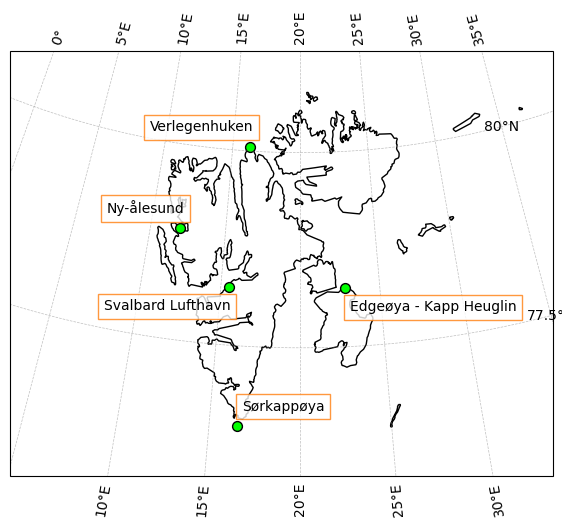

In [22]:
# Positions of the weather stations over a map of Svalbard 
map_svalbard_weather_stations(lons_sts, lats_sts, names_sts)
                       

### Methods

#### Rain-on-Snow events

The Jupyter Notebook uses daily values of temperature and precipitation to identify days with ROS events over Svalbard. 
Following Wickström et al. (2020), the Notebook defines ROS events as days with a daily-averaged temperature 
above 0°C and daily accumulated precipitation exceeding 1mm.

The Notebook only considers the winter days (December-January-February) between December 1990 and February 2022, with the 
29th of February excluded from the analysis. 


## Results

#### Observational gaps

To analyse temperature, precipitation, and ROS events over Svalbard, we first need to assess the number of missing values in the observations provided by weather stations. This evaluation helps determine the period covered by each weather station, and provides a qualitative understanding of whether the gaps in the observations could potentially influence the conclusions of the study. 

The two subplots below show the percentage of daily observations recorded by each weather station in each winter season (December-January-February, with the exclusion of the 29th of February) between December 1990 and February 2022. 
The upper plot shows the results for the 2m temperature, whereas the lower plot for the total precipitation. Empty circles highlight the winter seasons when no observations where recorded, whereas black circles the winter seasons without observational gaps. 

Two weather stations, Svalbard Lufthavn and Ny-Ålesund, offer a good coverage of temperature and precipitation over the selected period. The percentage of observations at these two stations surpasses 75% for the majority of the winter seasons, even reaching 100% in some occasions. The only exception is at Ny-Ålesund during the 2004/2005 winter season, when the percentage of temperature observations ranges between 25 and 50%. The limited number of observational gaps makes us believe that the missing values might only little affect the estimates of ROS events.  

The other three weather stations do not provide measurements for the total precipitation, but only for the 2m temperature. This means that ROS events can only be studied at Svalbard Lufthavn and Ny-Ålesund. 
However, the temperature observations at these three locations are valuable as they can be used to further evaluate the performace of ERA5 and CARRA. We also note that the remaining weather stations cover a subset of the selected period. The stations at Sørkappøya and Edgeøya - Kapp Heuglin provide, respectively, the shortest and the longest time series. The former starts in December 2010, while the latter in December 1992. Furthermore, we note significant gaps in the data collected by these three weather stations. For example, the station at Verlegenhuken has a three-winter gaps between December 2007 and February 2010. 


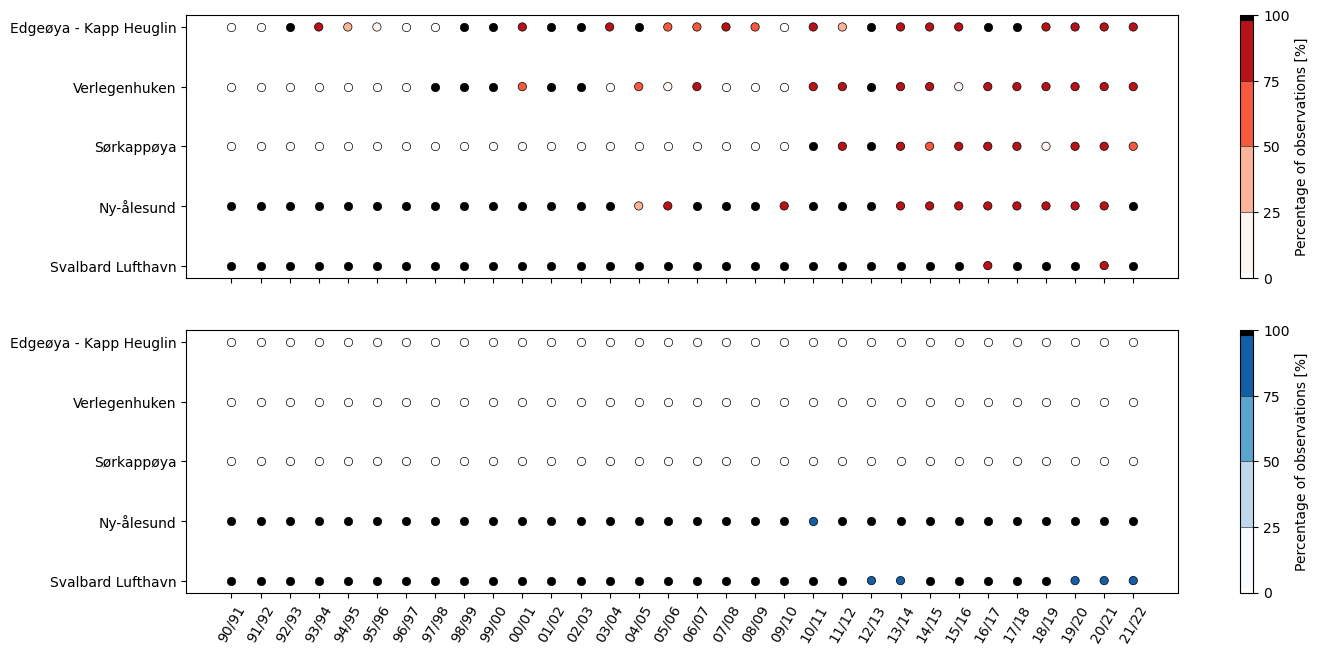

In [23]:
obs_percentage_per_djf_in_sts(names_sts, year_start, year_stop, df_stations_t2m, df_stations_tp)

#### Comparison: 2m Temperature and Total Precipitation

In [24]:
dc_t2m_at_sts, dc_diff_t2m_at_sts, dc_tp_at_sts, dc_diff_tp_at_sts = \
    values_at_all_stations(df_stations_t2m, df_stations_tp, da_era5_t2m, da_era5_tp, da_carra_west_t2m, da_carra_west_tp, da_carra_east_t2m, da_carra_east_tp, lons_sts, lats_sts, year_start, year_stop)

The figure below provides a comparison between the daily-averaged 2m temperature from the weather stations and the three reanalysis datasets. The figure is organized in fifteen scatter plots, arranged in five rows and three 
columns. Each row refers to a specific weather station, while each column to a reanalysis dataset. The left column compares the 2m temperature data from the weather stations (x-axis) and ERA5 (y-axis). The middle and right columns show the comparisons with CARRA-West and CARRA-East, respectively.

The scatter plots reveal a strong linear relationship between the observed temperatures and the reanalysis data, suggesting good agreement overall. However, the Verlegenhuken station is an outlier, showing a discrepancy of over 15°C between observed and reanalysis data. This discrepancy will be discussed in more detail later in the Notebook.

The figure suggests that CARRA-West and CARRA-East better describe temperature variations over Svalbard with respect to ERA5, with few exceptions. Indeed, the root mean square errors (RMSEs) indicate that CARRA-West and CARRA-East reproduce the day-to-day variability of 2m temperature better than ERA5 in the region. However, the biases do not clearly help discriminate among the reanalysis datasets. For instance, ERA5 returns the smallest biases at two stations, Edgeøya - Kapp Heuglin and Verlegenhuken. 


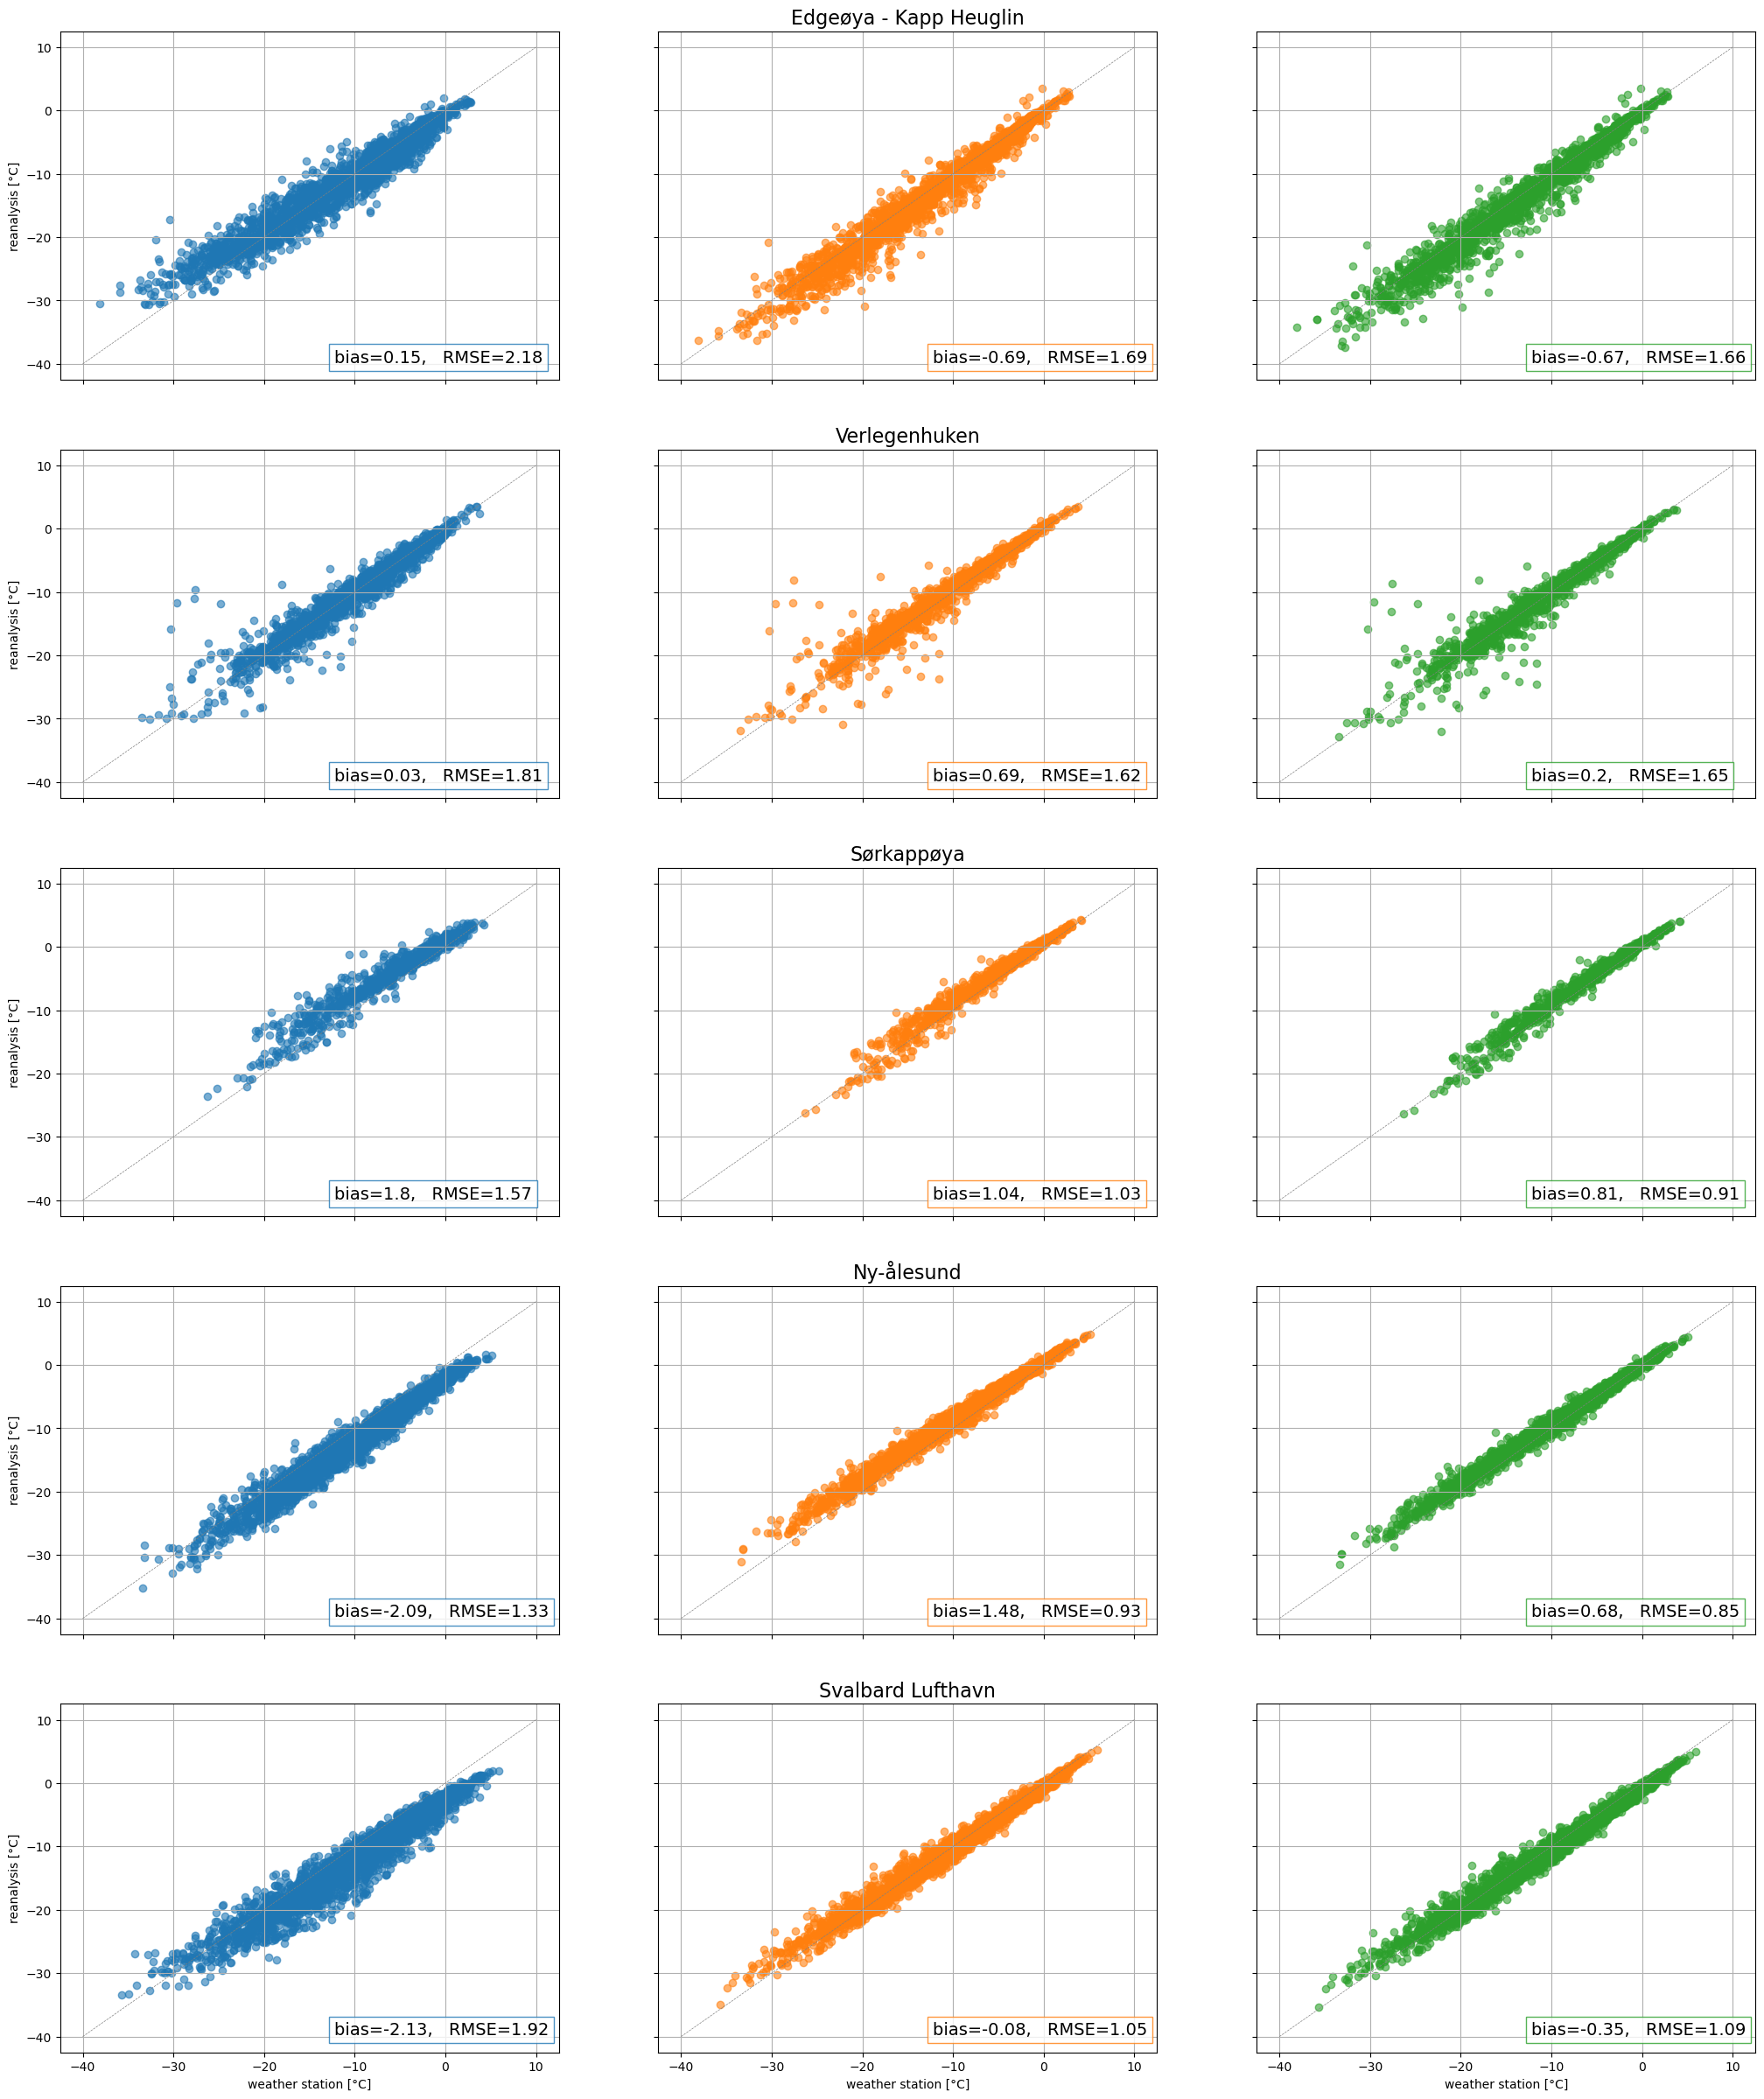

In [25]:
plots_t2m(dc_t2m_at_sts, dc_diff_t2m_at_sts, names_sts)


The figure below helps visualize the period when the 2m temperature readings from the Verlegenhuken weather station and the reanalysis datasets diverge significantly.  

From the upper subplot, which shows the difference between the temperature provided by the CARRA-East dataset and the weather station at Verlegenhuken, we note that the maximum discrepancy between the reanalysis dataset and the observations occurs in the second half of the winter seasons 1997/1998. 

The lower subplots provide a close look at this winter season, showing the 2m temperature timeseries from the weather station, represented by a blue line, and the reanalysis datasets. The left subplot shows the results for ERA5, the middle for CARRA-West, and the right for CARRA-East. It’s worth noting that, irrespective of the reanalysis dataset, a discrepancy is evident during the first 20 days of February, as if the reanalysis datasets were able to reproduce the local maximum in temperature, but with a lag of 10 days circa. 

A more comprehensive analysis would be needed to understand the reasons behind such a discrepancy. However, such analysis falls outside the scope of the Jupyter Notebook. 


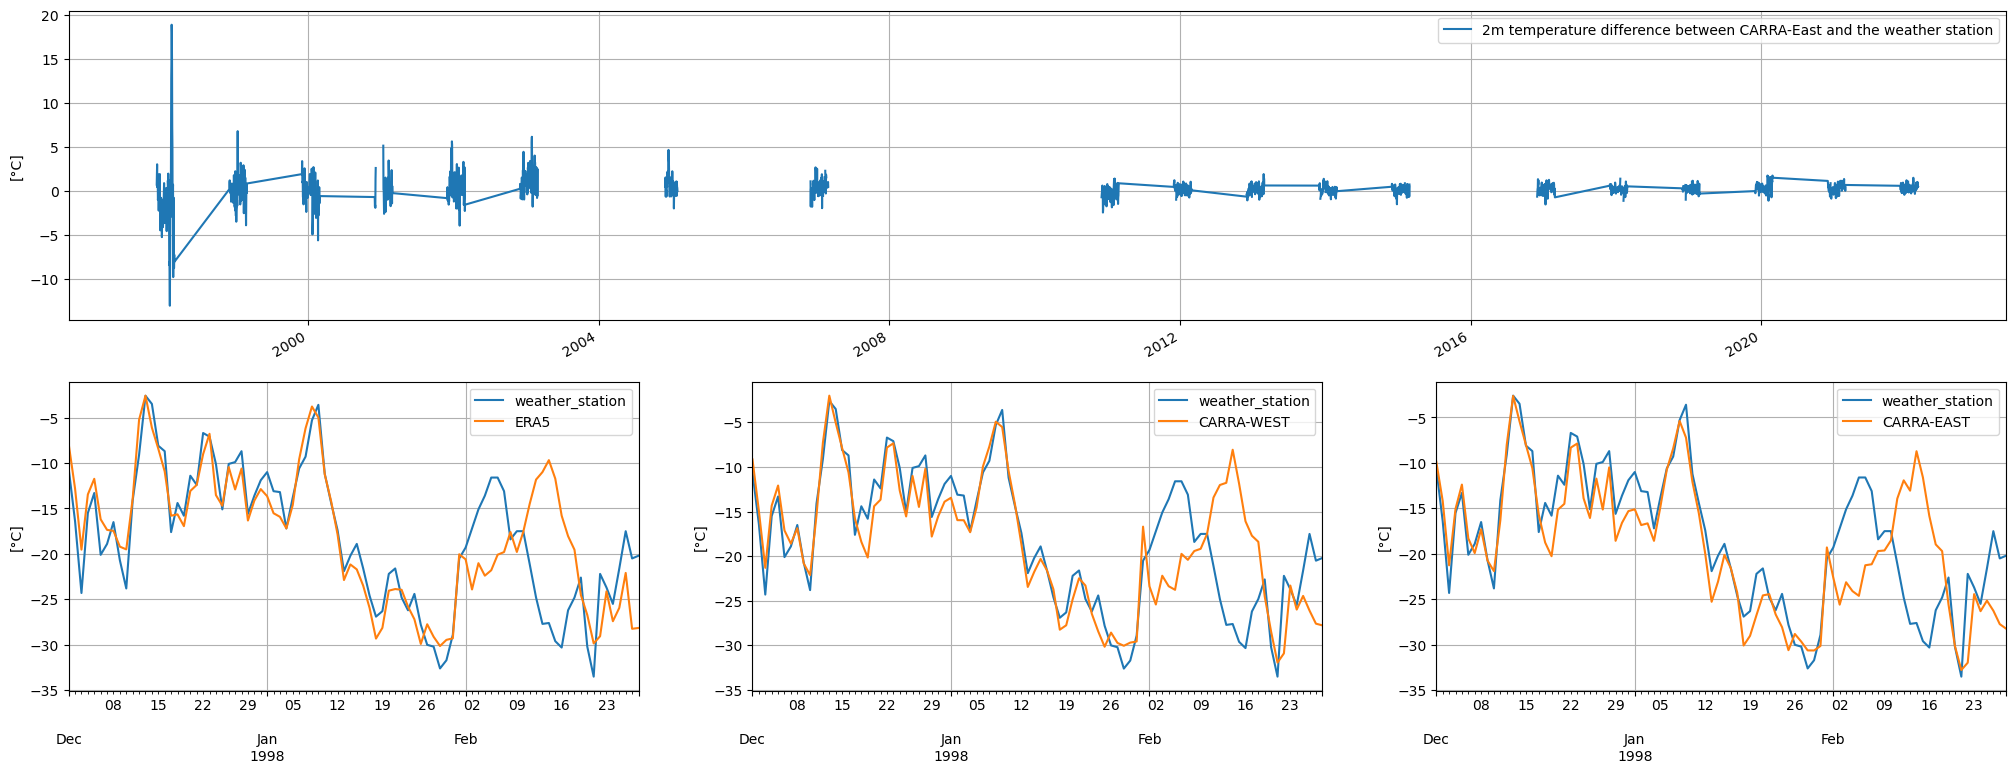

In [26]:
show_t2m_difference_at_verlegenhuken(dc_t2m_at_sts, dc_diff_t2m_at_sts)


The figure below provides a comparison between the daily-accumulated total precipitation from the weather stations and the three reanalysis datasets. This figure follows the same structure as the one for the 2m temperature, but only contains the results for Ny-Ålesund and Svalbard Lufthavn because the total precipitation is not provided at the other three locations. 

As with the 2m temperature, we note a linear relationship between the daily-accumulated precipitation from the weather stations and from ERA5, CARRA-West and CARRA-East. The analysis of the bias and the RMSE indicate that CARRA-West and CARRA-East better agree with the observations when compared to ERA5. This same analysis does not discrimintate between CARRA-West and CARRA-East which, instead, return comparable results. 


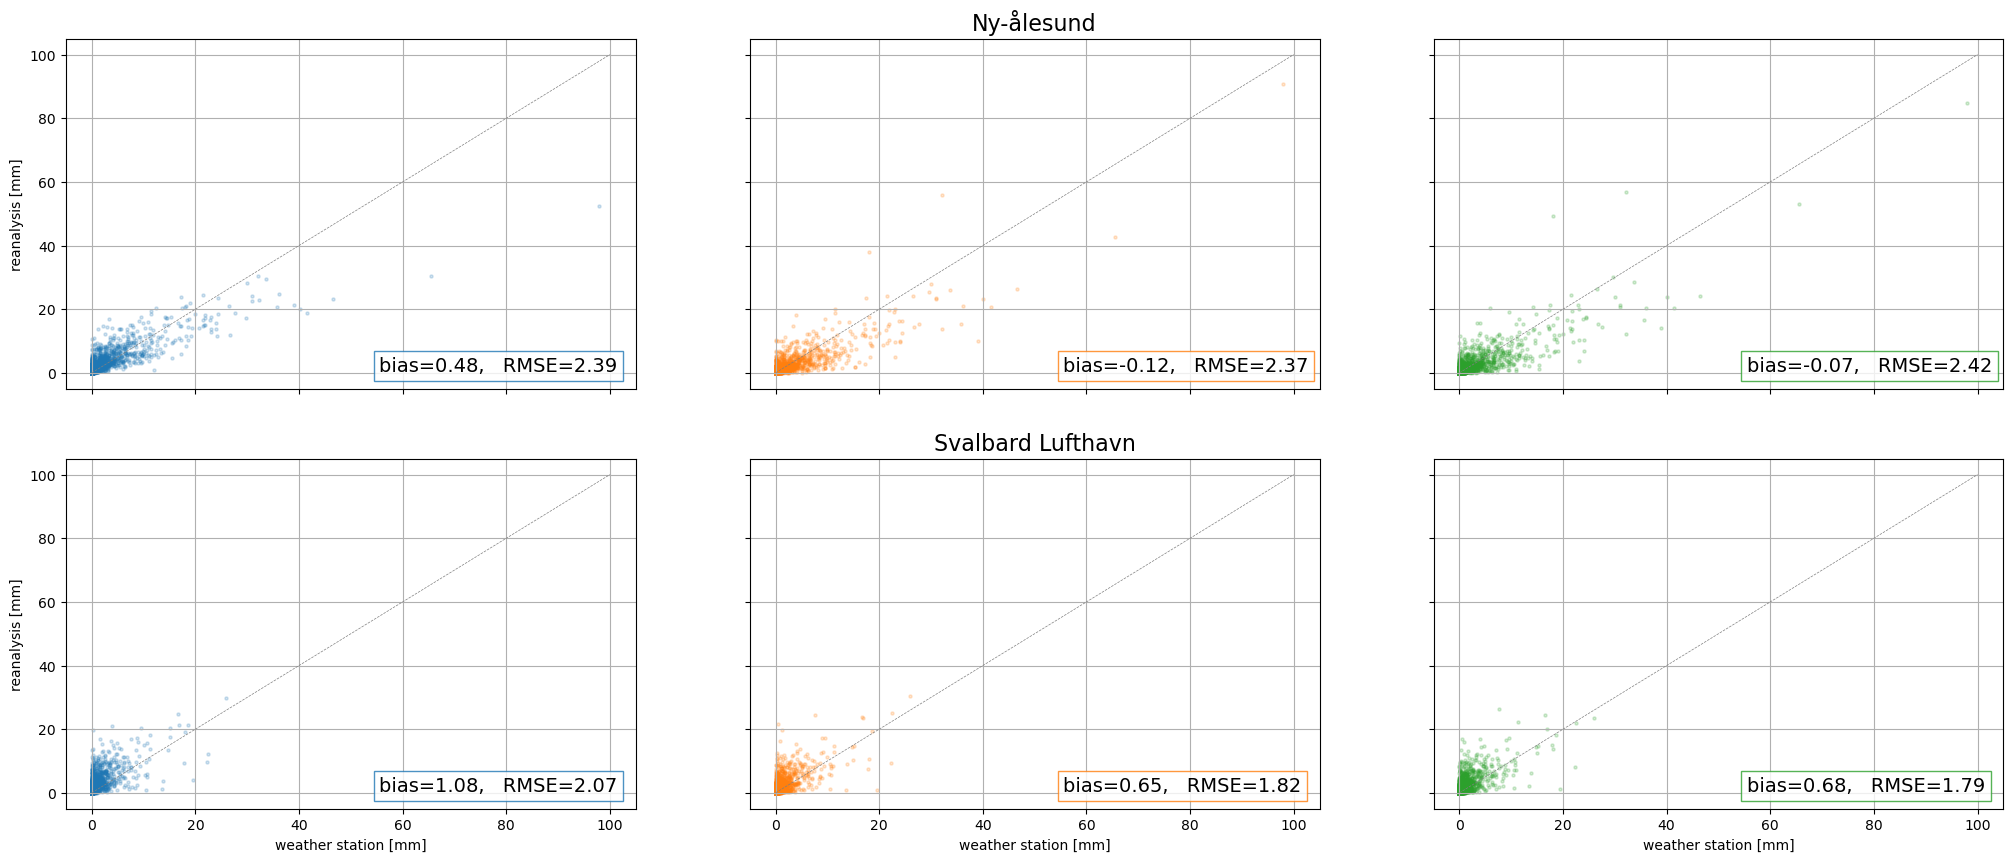

In [27]:
plots_tp(dc_tp_at_sts, dc_diff_tp_at_sts, names_sts)


#### Comparison: rain-on-snow (ROS) events

In [28]:
# Count number of ROS events for each winter at Ny-Ålesund according to:
#    - weather station
#    - ERA5
#    - CARRA-West
#    - CARRA-East
df_n_ros_ny_alesund = monthly_ros_events_at_single_station(dc_t2m_at_sts[names_sts[3]], dc_tp_at_sts[names_sts[3]], year_start, year_stop, obs_gaps=False)
df_n_ros_ny_alesund_samegaps = monthly_ros_events_at_single_station(dc_t2m_at_sts[names_sts[3]], dc_tp_at_sts[names_sts[3]], year_start, year_stop, obs_gaps=True)    #  here, we artifically fill the reanalysis data with the same gaps as in the observations

# Same as above, but for the weather station at Svalbard Lufthavn 
df_n_ros_svalbard_lufthavn = monthly_ros_events_at_single_station(dc_t2m_at_sts[names_sts[4]], dc_tp_at_sts[names_sts[4]], year_start, year_stop, obs_gaps=False)
df_n_ros_svalbard_lufthavn_samegaps = monthly_ros_events_at_single_station(dc_t2m_at_sts[names_sts[4]], dc_tp_at_sts[names_sts[4]], year_start, year_stop, obs_gaps=True)


The differences between the three reanalysis datasets become more evident when ROS events are considered.  

The figure below shows the number of ROS events for each winter season between December 1990 and February 2022, with the upper subplot showing the results for Ny-Ålesund and the lower subplot for Svalbard Lufthavn. 

The performance of ERA5, CARRA-West, and CARRA-East depends on the weather station. At Ny-Ålesund, simple visual inspection indicates that CARRA-East better reproduces the winter-to-winter variations in the number of ROS events. Instead, CARRA-West and ERA5 tend to overestimate and understimate this number, respectively. The issue with ERA5 might be fue to the reanalysis data underestimating the 2m temperature at Ny-Ålesund, as previously shown in the Jupyter Notebook. 

Visual inspection also seems to indicate that CARRA-West and CARRA-East better reproduce the winter-to-winter variations of ROS events at Svalbard Lufthavn. Indeed, while CARRA-West and CARRA-East return comparable results, they both show an overall smaller discrepancy with the observations when compared to ERA5. For instance, the averaged absolute difference of the number of ROS events from observations and ERA5 is appriximately 1.8, whereas it is 1.2 and 1 for CARRA-West and CARRA-East, respectively (the calculation is shown below). It is worth noting, however, that this conclusion is not as clear as for Ny-Ålesund, as both CARRA-West and CARRA-East tend to overestimate the number the ROS events at Svalbard Lufthavn, while ERA5 tends to underestimate it. 


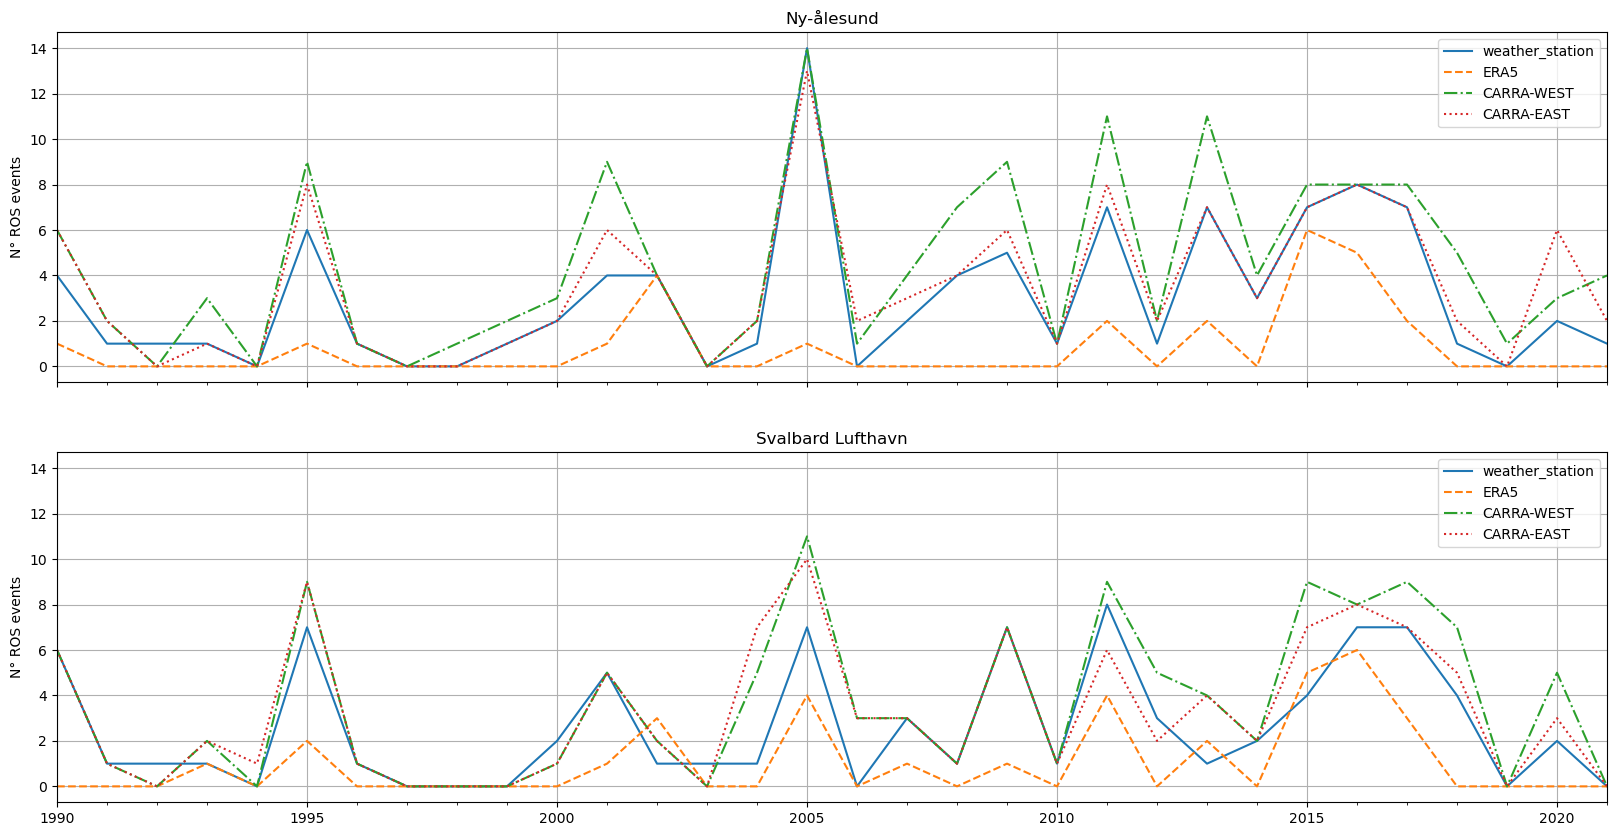

In [29]:
plot_ros_events(df_n_ros_ny_alesund_samegaps, df_n_ros_svalbard_lufthavn_samegaps, names_sts)

In [30]:
print('At the Svalbard Lufthavn weather station, the averaged absolute difference between the number of ROS events provided by the weather station and: ')
print('')
print('   ERA5 is approximately ', np.round(np.mean(np.abs(df_n_ros_svalbard_lufthavn_samegaps['ERA5'] - df_n_ros_svalbard_lufthavn_samegaps['weather_station'])), 1))
print('   CARRA-West is approximately ', np.round(np.mean(np.abs(df_n_ros_svalbard_lufthavn_samegaps['CARRA-WEST'] - df_n_ros_svalbard_lufthavn_samegaps['weather_station'])), 1))
print('   CARRA-East is approximately ', np.round(np.mean(np.abs(df_n_ros_svalbard_lufthavn_samegaps['CARRA-EAST'] - df_n_ros_svalbard_lufthavn_samegaps['weather_station'])), 1))
print('--------')

At the Svalbard Lufthavn weather station, the averaged absolute difference between the number of ROS events provided by the weather station and: 

   ERA5 is approximately  1.8
   CARRA-West is approximately  1.2
   CARRA-East is approximately  1.0
--------


We conclude with a brief discussion on the linear trends in the number of ROS events at Ny-Ålesund and at Svalbard Lufthavn. The analysis of the linear trends serves a dual purpose. At first, it helps evaluate the quality of the reanalysis datasets. Secondly, it helps quantify the impact of climate change on the occurrence of ROS events over Svalbard. The results from the linear trends are shown in the cells below. 

In agreement with the previous figure, the linear trends suggest an increase in the number of ROS events at both Ny-Ålesund and Svalbard Lufthavn since 1990. The linear trend provided by CARRA-East aligns most closely with observations at Ny-Ålesund. At Svalbard Lufthavn, the results are more ambiguous, with both CARRA-East and ERA5 best resembling the observations. We should note, however, that the width of the confidence intervals questions the statistical significance of the results. Therefore, both the observations and the reanalysis datasets suggest that 
longer timeseries are needed to obtain statistically significant results and to determine whether climate change has affected the occurrence of ROS events over the Svalbard Archipelago. 


In [31]:
linear_trend_and_uncertainty_ros_at_single_station(df_n_ros_ny_alesund_samegaps, 'Ny-Ålesund')

slope +/- 95% confidence interval at Ny-Ålesund:

    0.08 +/- 0.13  (weather_station)
    0.04 +/- 0.06  (ERA5)
    0.12 +/- 0.15  (CARRA-WEST)
    0.09 +/- 0.12  (CARRA-EAST)


In [32]:
linear_trend_and_uncertainty_ros_at_single_station(df_n_ros_svalbard_lufthavn_samegaps, 'Svalbard Lufthavn')

slope +/- 95% confidence interval at Svalbard Lufthavn:

    0.05 +/- 0.10  (weather_station)
    0.05 +/- 0.06  (ERA5)
    0.12 +/- 0.13  (CARRA-WEST)
    0.06 +/- 0.12  (CARRA-EAST)


## References 

Hansen, B. B., Isaksen, K., Benestad, R. E., Kohler, J., Pedersen, Å. Ø., et al. 2014 Warmer and wetter winters: Characteristics and implications of an extreme weather event in the High Arctic. Environ. Res. Lett., 9(11), 114021. https://doi.org/10.1088/ 1748-9326/9/11/114021.

Hanssen-Bauer, I., Førland, E. J., Hisdal, H., Mayer, S., Sandø, A. B., et al. 2019 Climate in Svalbard 2100 – a knowledge base for climate adaptation. NCCS Report no. 1/2019 (www.klimaservicesenter.no).

Hersbach, H., et al. 2020 The ERA5 global reanalysis. Q.J.R. Meteorol. Soc. 146, 1990–2049. https://doi.org/10.1002/qj.3803.

Peeters et al. 2019 Spatiotemporal patterns of rain-on-snow and basal ice in high Arctic Svalbard: detection of a climate-cryosphere regime shift. Environ. Res. Lett., 14, 015002. doi:10.1088/1748-9326/aaefb3.

Rantanen, M., Karpechko, A. Y., Lipponen, A., Nordling, K., Hyvärinen, O., et al. 2022 The Arctic has warmed nearly four times faster than the globe since 1979. Commun. Earth Environ. 3, 168. doi:10.1038/s43247-022-00498-3.

Wickström, S., Jonassen, M. O., Cassano, J. J., Vihma, T. 2020 Present temperature, precipitation, and rain‐on‐snow climate in Svalbard. J. GJ. Geophys. Res. Atmos.5, e2019JD032155. https://doi.org/10.1029/2019JD032155.
